In [482]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from data_preprocessing import data_preprocessing
from get_data import Dataset
from tensorflow.keras import layers, callbacks

from warnings import filterwarnings
filterwarnings('ignore')

In [483]:
currencies = ['BTCUSDT', 'BNBBUSD', 'ETHBUSD', 'SOLBUSD']

for currency in currencies:
    Dataset(interval='hour', coin=currency)

currency_pair_data = {
    currency: data_preprocessing(currency).dataset
    for currency in currencies
}

In [484]:
df = currency_pair_data['BTCUSDT']

In [485]:
cols = [col for col in df.columns if 'interval' in col]
for col in cols:
    df[col] = df[col].fillna(df[col].mean())

In [486]:
# plot_features = df
# plot_features.index = open_time
# _ = plot_features.plot(subplots=True)

# plot_features = df[:480]
# plot_features.index = open_time[:480]
# _ = plot_features.plot(subplots=True)

In [487]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [488]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [489]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [490]:
train_df

,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,hour,...,Trades_TakerBuyBaseAssetVolume_mean(interval),Trades_TakerBuyBaseAssetVolume_count(interval),Trades_TakerBuyQuoteAssetVolume_sum(interval),Trades_TakerBuyQuoteAssetVolume_max(interval),Trades_TakerBuyQuoteAssetVolume_min(interval),Trades_TakerBuyQuoteAssetVolume_mean(interval),Trades_TakerBuyQuoteAssetVolume_count(interval),High_Close_diff,Close_Low_diff,Open_Close_diff
OpenTime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 11:00:00,4261.48,4313.62,4261.32,4308.83,47.181007,2.023661e+05,171,35.160503,1.509525e+05,11,...,28.801228,2403.0,4.485135e+08,1812465.4,14.7,1.866473e+05,2403.0,4.79,47.51,47.35
2017-08-17 12:00:00,4308.83,4328.69,4291.37,4315.32,23.234917,1.003048e+05,102,21.448070,9.260828e+04,12,...,28.801228,2403.0,4.485135e+08,1812465.4,14.7,1.866473e+05,2403.0,13.37,23.95,6.49
2017-08-17 13:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36,4.802861,2.079532e+04,13,...,28.801228,2403.0,4.485135e+08,1812465.4,14.7,1.866473e+05,2403.0,21.10,14.98,-5.94
2017-08-17 14:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25,2.602292,1.129135e+04,14,...,28.801228,2403.0,4.485135e+08,1812465.4,14.7,1.866473e+05,2403.0,0.00,62.58,33.37
2017-08-17 15:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4.239503e+03,28,0.814655,3.552747e+03,15,...,28.801228,2403.0,4.485135e+08,1812465.4,14.7,1.866473e+05,2403.0,17.16,27.37,27.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-04 01:00:00,57958.60,58084.60,57745.90,57764.42,1840.547700,1.065454e+08,65626,905.853700,5.243780e+07,1,...,1632.828890,165.0,8.113309e+09,103732910.0,17163962.0,4.917157e+07,165.0,320.18,18.52,-194.18
2021-05-04 02:00:00,57764.42,57764.43,57326.01,57564.87,1904.070000,1.095544e+08,76078,923.641900,5.314227e+07,2,...,1884.053397,122.0,6.947053e+09,95608850.0,20180000.0,5.694305e+07,122.0,199.56,238.86,-199.55
2021-05-04 03:00:00,57564.86,57575.05,56602.73,56783.94,3198.868000,1.825414e+08,141350,1523.250400,8.694346e+07,3,...,3293.245177,30.0,2.856843e+09,171557760.0,36426616.0,9.522809e+07,30.0,791.11,181.21,-780.92


In [491]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift #48

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [492]:
w = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Close'])
w.column_indices

{'Open': 0,
 'High': 1,
 'Low': 2,
 'Close': 3,
 'Volume': 4,
 'QuoteAssetVolume': 5,
 'NumberOfTrades': 6,
 'TakerBuyBaseAssetVolume': 7,
 'TakerBuyQuoteAssetVolume': 8,
 'hour': 9,
 'day': 10,
 'month': 11,
 'year': 12,
 'Open_sum(day)': 13,
 'Open_max(day)': 14,
 'Open_min(day)': 15,
 'Open_mean(day)': 16,
 'Open_count(day)': 17,
 'High_sum(day)': 18,
 'High_max(day)': 19,
 'High_min(day)': 20,
 'High_mean(day)': 21,
 'High_count(day)': 22,
 'Low_sum(day)': 23,
 'Low_max(day)': 24,
 'Low_min(day)': 25,
 'Low_mean(day)': 26,
 'Low_count(day)': 27,
 'Volume_sum(day)': 28,
 'Volume_max(day)': 29,
 'Volume_min(day)': 30,
 'Volume_mean(day)': 31,
 'Volume_count(day)': 32,
 'QuoteAssetVolume_sum(day)': 33,
 'QuoteAssetVolume_max(day)': 34,
 'QuoteAssetVolume_min(day)': 35,
 'QuoteAssetVolume_mean(day)': 36,
 'QuoteAssetVolume_count(day)': 37,
 'NumberOfTrades_sum(day)': 38,
 'NumberOfTrades_max(day)': 39,
 'NumberOfTrades_min(day)': 40,
 'NumberOfTrades_mean(day)': 41,
 'NumberOfTrades_co

In [493]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        
    tf.ensure_shape(inputs, [None, self.input_width, None])
    tf.ensure_shape(labels, [None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [494]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 81)
Inputs shape: (3, 6, 81)
Labels shape: (3, 1, 1)


In [495]:
w.example = example_inputs, example_labels

In [496]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8), dpi=200)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    idx_to_plot = [0, len(inputs) - 1]
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
                 marker='.', label='Inputs')
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], 
                        marker='X', edgecolors='k', label='Predictions', 
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
    
WindowGenerator.plot=plot

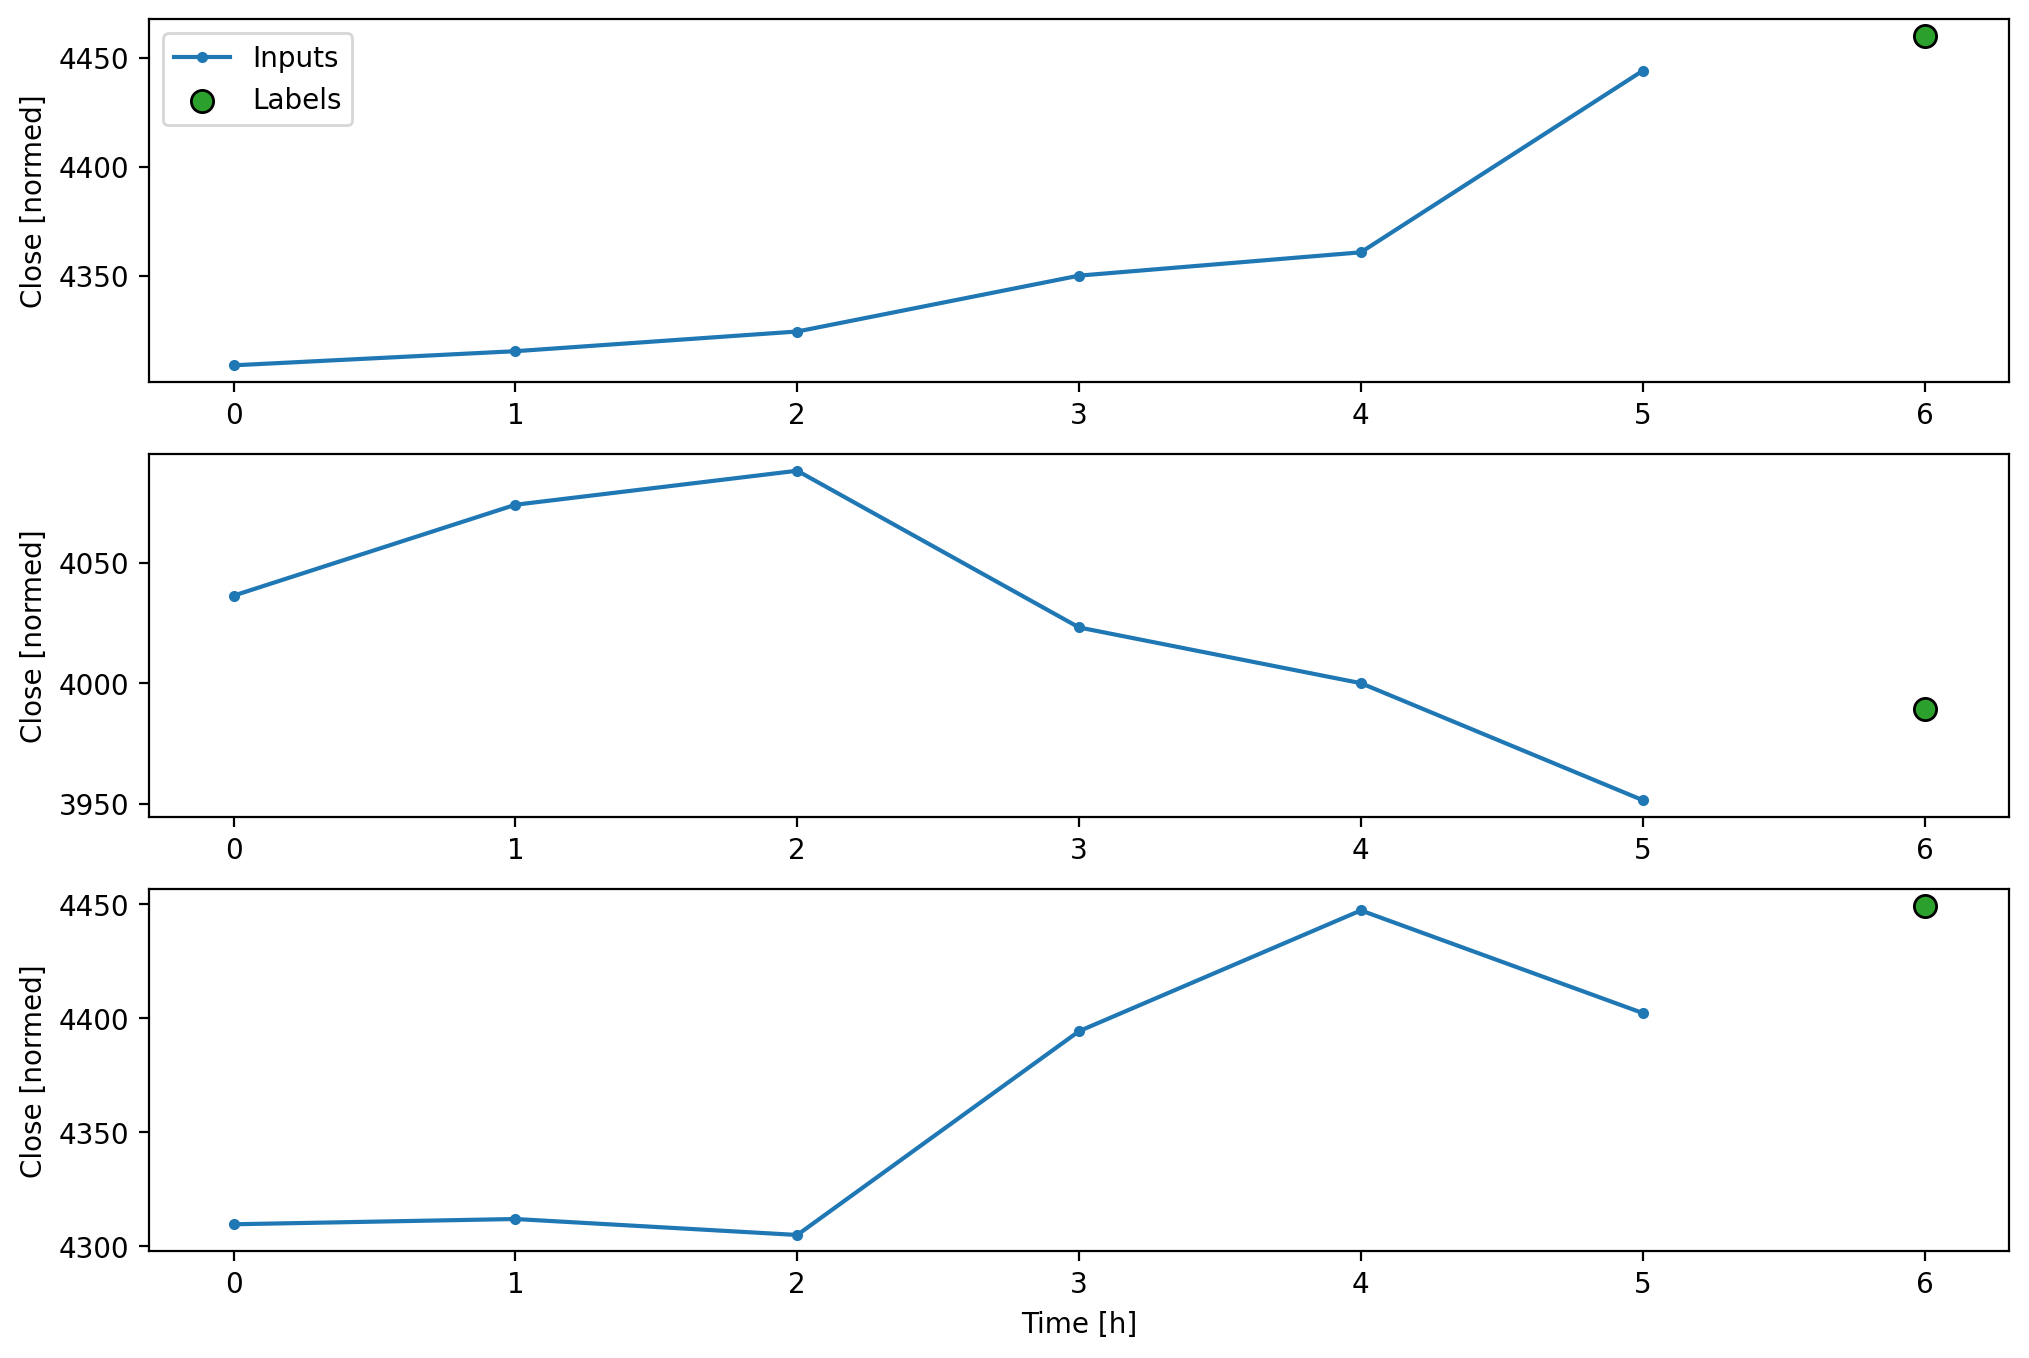

In [497]:
w.plot()

In [498]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data= data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1,  
        shuffle=False, 
        batch_size=32)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [499]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [500]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=patience, 
                                             mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(), 
                  optimizer=tf.optimizers.Adam(), 
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, 
                        validation_data=window.val, 
                        callbacks=[early_stopping])
    
    return history

In [501]:
def get_model(kind='lstm'):
    if kind == 'lstm':
        model = tf.keras.models.Sequential([
            layers.LSTM(256, return_sequences=True),
            layers.Dropout(0.3),
            layers.Dense(units=64),
            layers.Dropout(0.3),
            layers.Dense(units=1)
        ])
    elif kind == 'mlp':
        model = tf.keras.models.Sequential([
            layers.Dense(128),
            layers.Dropout(0.3),
            layers.Dense(32),
            layers.Dropout(0.3),
            layers.Dense(1)
        ])        
    return model

model = get_model('lstm')

In [502]:
bitcoin_window = WindowGenerator(input_width=13, label_width=13, shift=1, label_columns=['Close'])

In [503]:
print('Input shape:', bitcoin_window.example[0].shape)
print('Output shape:', model(bitcoin_window.example[0]).shape)

Input shape: (32, 13, 81)
Output shape: (32, 13, 1)


In [504]:
val_performance = {}
performance = {}

In [505]:
history = compile_and_fit(model, bitcoin_window, patience=5)

val_performance['LSTM'] = model.evaluate(bitcoin_window.val)
performance['LSTM'] = model.evaluate(bitcoin_window.test, verbose=0)

Epoch 1/50


2022-12-04 10:50:44.499003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 10:50:44.660178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 10:50:45.044632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1013/1013 [==============================] - ETA: 0s - loss: 199929248.0000 - mean_absolute_error: 9540.2510

2022-12-04 10:51:04.786669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 10:51:04.848029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1013/1013 [==============================] - 24s 22ms/step - loss: 199929248.0000 - mean_absolute_error: 9540.2510 - val_loss: 1227549440.0000 - val_mean_absolute_error: 33895.3750
Epoch 2/50
1013/1013 [==============================] - 21s 20ms/step - loss: 149179184.0000 - mean_absolute_error: 6334.7866 - val_loss: 1047221568.0000 - val_mean_absolute_error: 31121.8223
Epoch 3/50
1013/1013 [==============================] - 21s 20ms/step - loss: 150477168.0000 - mean_absolute_error: 7089.4844 - val_loss: 994353536.0000 - val_mean_absolute_error: 30262.2988
Epoch 4/50
1013/1013 [==============================] - 20s 20ms/step - loss: 150130096.0000 - mean_absolute_error: 7322.7217 - val_loss: 974295680.0000 - val_mean_absolute_error: 29930.2363
Epoch 5/50
1013/1013 [==============================] - 21s 20ms/step - loss: 148470688.0000 - mean_absolute_error: 7364.6489 - val_loss: 962358656.0000 - val_mean_absolute_error: 29730.1504
Epoch 6/50
1013/1013 [==============================] 

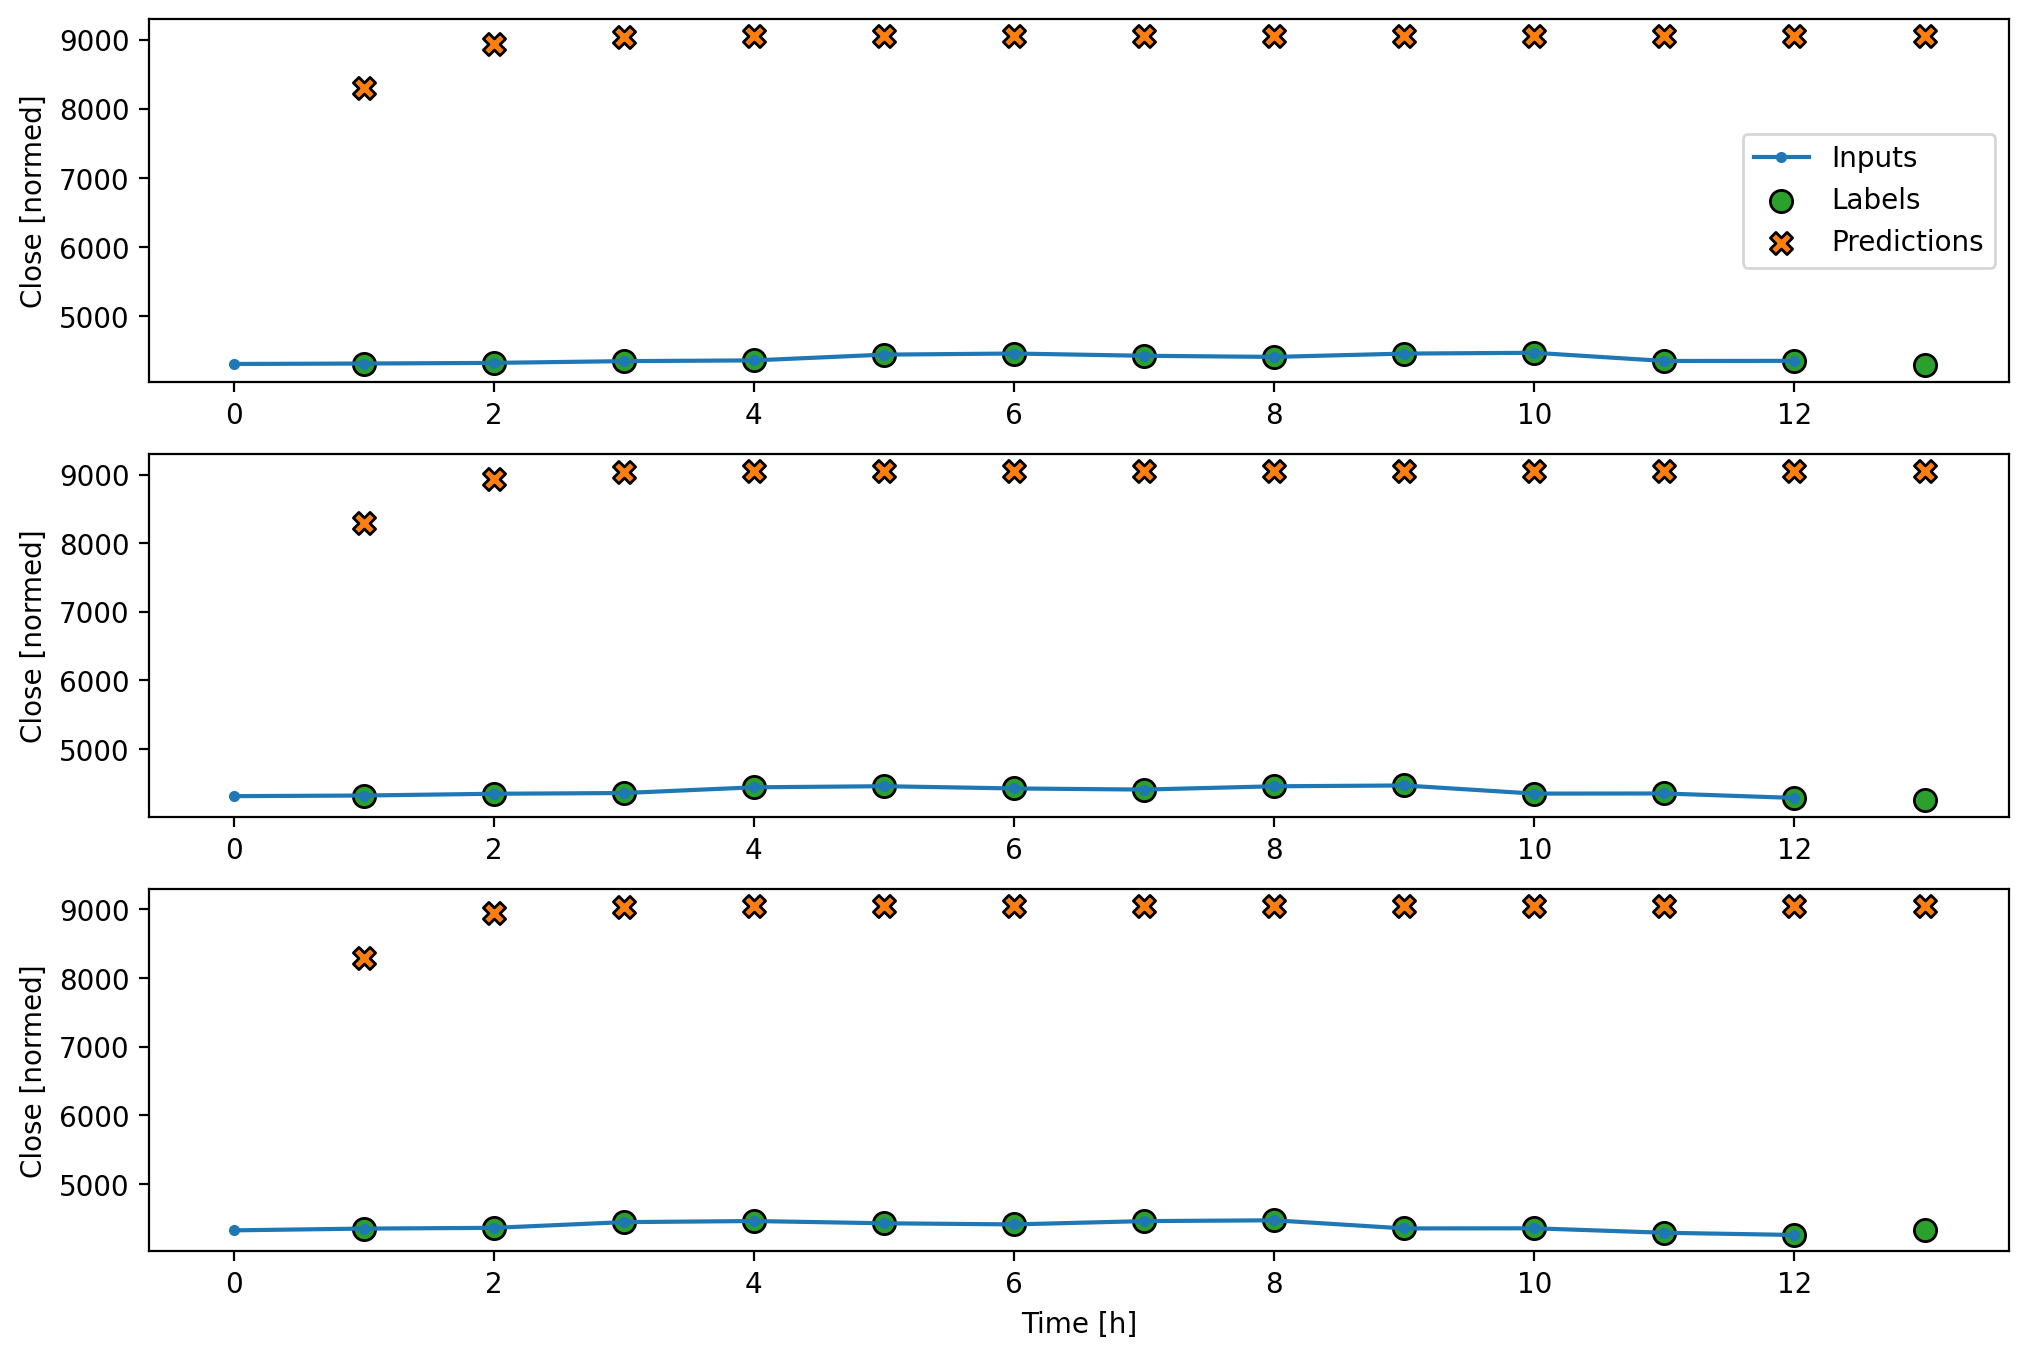

In [506]:
bitcoin_window.plot(model)

In [507]:
performance

{'LSTM': [355320800.0, 14417.83203125]}

In [509]:
val_performance

{'LSTM': [438508064.0, 18846.294921875]}

In [510]:
predictions = model.predict(bitcoin_window.test)

2022-12-04 11:06:33.473892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-04 11:06:33.532516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 2s 9ms/step


In [511]:
predictions.shape

(4619, 13, 1)

In [512]:
# for i in bitcoin_window.test:
#     print(i[0].shape, i[1].shape)
#     break
# len(bitcoin_window.test)
# len(test_df) / 32
# for i in bitcoin_window.test.take(-1):
#     print(i[0])

In [513]:
train_predictions = model.predict(bitcoin_window.train)

1013/1013 [==============================] - 8s 8ms/step


In [514]:
train_predictions.shape

(32406, 13, 1)